In [26]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [30]:

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random_seed = 123
learning_rate = 0.1
num_epochs = 5
batch_size = 256

num_features = 784
num_classes = 10

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape) #NCHW
    print('Image label dimensions:', labels.shape)
    break



Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [31]:

class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self, x):
        z = self.linear(x)
        probas = F.softmax(z, dim=1)
        return z, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(DEVICE)


optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [32]:
# Manual seed for deterministic data loader
torch.manual_seed(random_seed)

def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100
    

start_time = time.time()
epoch_costs = []
for epoch in range(num_epochs):
    avg_cost = 0.
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        avg_cost += cost
        
        optimizer.step()
        
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))
            
    with torch.set_grad_enabled(False):
        avg_cost = avg_cost/len(train_dataset)
        epoch_costs.append(avg_cost)
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 000/234 | Cost: 2.3026
Epoch: 001/005 | Batch 050/234 | Cost: 0.7693
Epoch: 001/005 | Batch 100/234 | Cost: 0.5321
Epoch: 001/005 | Batch 150/234 | Cost: 0.5617
Epoch: 001/005 | Batch 200/234 | Cost: 0.5501
Epoch: 001/005 training accuracy: 88.05%
Time elapsed: 0.06 min
Epoch: 002/005 | Batch 000/234 | Cost: 0.4793
Epoch: 002/005 | Batch 050/234 | Cost: 0.3686
Epoch: 002/005 | Batch 100/234 | Cost: 0.4535
Epoch: 002/005 | Batch 150/234 | Cost: 0.3731
Epoch: 002/005 | Batch 200/234 | Cost: 0.4791
Epoch: 002/005 training accuracy: 89.26%
Time elapsed: 0.12 min
Epoch: 003/005 | Batch 000/234 | Cost: 0.4057
Epoch: 003/005 | Batch 050/234 | Cost: 0.4456
Epoch: 003/005 | Batch 100/234 | Cost: 0.3770
Epoch: 003/005 | Batch 150/234 | Cost: 0.3893
Epoch: 003/005 | Batch 200/234 | Cost: 0.2996
Epoch: 003/005 training accuracy: 89.94%
Time elapsed: 0.17 min
Epoch: 004/005 | Batch 000/234 | Cost: 0.4298
Epoch: 004/005 | Batch 050/234 | Cost: 0.3918
Epoch: 004/005 | Batch 100

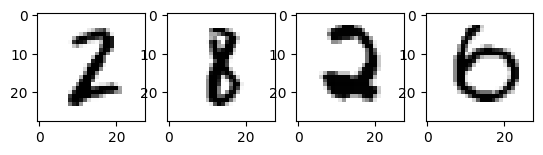

In [33]:
import matplotlib.pyplot as plt
batch_num = 1
for i, (features, targets) in enumerate(test_loader):
    if i == batch_num:
        break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)


plt.show()

In [34]:
_, predictions = model.forward(features[:4].view(-1, 28*28).to(DEVICE))
predictions = torch.argmax(predictions, dim=1
                           )
print('Predicted labels', predictions)

Predicted labels tensor([2, 8, 2, 0])
